In [30]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [32]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [33]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [34]:
tf.keras.backend.clear_session()

In [35]:
subject = 'Amazonas - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [36]:
data = pd.read_csv('2003_mo_model_input_AM.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amazonas - Consumo de Cimento (t),Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,28.193,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,31.226,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.484,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,31.596,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,32.919,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


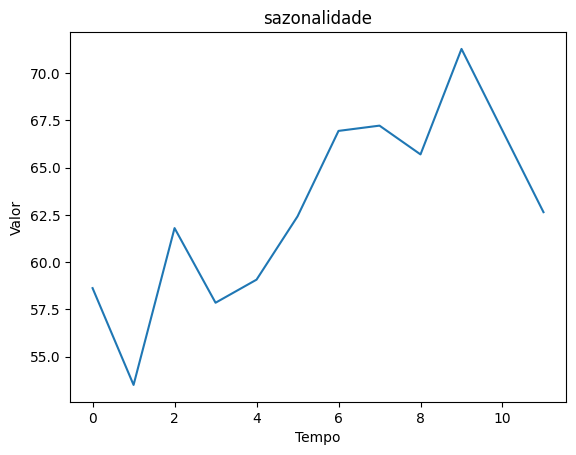

,sazonalidade
sazonalidade,
0,58.629342
1,53.507726
2,61.805183
3,57.855957
4,59.077386
5,62.424988
6,66.948079
7,67.226599
8,65.704008


In [37]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [38]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,58.629342,28.193
1,2003-2,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,53.507726,31.226
2,2003-3,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,61.805183,33.484
3,2003-4,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,57.855957,31.596
4,2003-5,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,59.077386,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.077386,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.424988,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.948079,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.226599,NaN


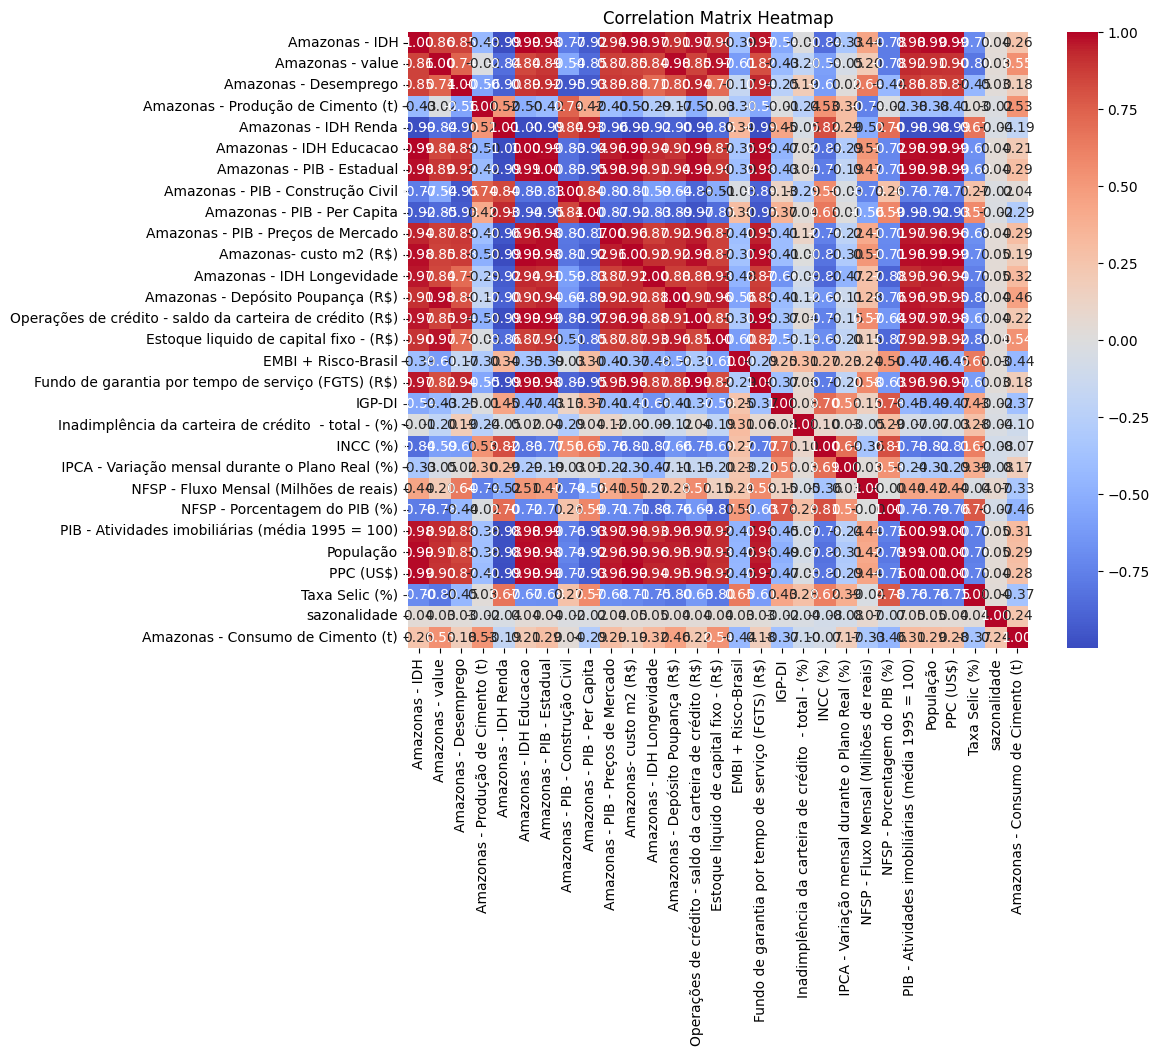

In [39]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [40]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.017357,-1.841109,-0.841381,-0.246822,1.663340,-1.742811,-1.725325,0.115495,1.032096,-1.955531,-1.679044,-2.569566,-1.741353,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-0.875159
1,-1.988164,-1.831498,-0.844328,-0.217639,1.647034,-1.724068,-1.704856,0.145069,1.057757,-1.907364,-1.657212,-2.517192,-1.730227,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.939713
2,-1.958970,-1.829607,-0.847276,-0.221378,1.630729,-1.705325,-1.684387,0.174644,1.083417,-1.859197,-1.636221,-2.464818,-1.719101,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.215044
3,-1.929776,-1.824180,-0.850223,-0.207299,1.614423,-1.686582,-1.663918,0.204218,1.109077,-1.811030,-1.616450,-2.412444,-1.707975,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.035911
4,-1.900583,-1.819720,-0.853171,-0.183234,1.598117,-1.667839,-1.643449,0.233793,1.134738,-1.762863,-1.597576,-2.360070,-1.696849,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.782031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.146285,0.624622,1.092028,-2.063199,-1.473281,1.364496,1.193835,-1.214518,-0.726615,1.324047,1.671951,0.893492,0.945332,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,0.911825
188,1.136919,0.664868,1.088543,-2.019550,-1.481951,1.364044,1.186279,-1.186673,-0.718777,1.320189,1.699059,0.866563,0.945332,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.595346
189,1.127552,0.713988,1.085058,-1.981485,-1.490620,1.363593,1.178724,-1.158827,-0.710938,1.316331,1.726502,0.839634,0.945332,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.755504
190,1.118186,0.765366,1.081573,-1.940641,-1.499290,1.363141,1.171169,-1.130982,-0.703100,1.312472,1.756700,0.812705,0.945333,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.857213


In [42]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      34.293
1      48.623
2      34.555
3      57.805
4      39.036
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Amazonas - Consumo de Cimento (t), Length: 249, dtype: float64

In [43]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.017357,-1.841109,-0.841381,-0.246822,1.663340,-1.742811,-1.725325,0.115495,1.032096,-1.955531,-1.679044,-2.569566,-1.741353,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-0.875159
1,-1.988164,-1.831498,-0.844328,-0.217639,1.647034,-1.724068,-1.704856,0.145069,1.057757,-1.907364,-1.657212,-2.517192,-1.730227,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.939713
2,-1.958970,-1.829607,-0.847276,-0.221378,1.630729,-1.705325,-1.684387,0.174644,1.083417,-1.859197,-1.636221,-2.464818,-1.719101,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.215044
3,-1.929776,-1.824180,-0.850223,-0.207299,1.614423,-1.686582,-1.663918,0.204218,1.109077,-1.811030,-1.616450,-2.412444,-1.707975,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.035911
4,-1.900583,-1.819720,-0.853171,-0.183234,1.598117,-1.667839,-1.643449,0.233793,1.134738,-1.762863,-1.597576,-2.360070,-1.696849,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.782031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.448925,0.452650,1.390527,-0.823205,-1.348877,1.389676,1.169567,-1.503954,-1.462487,0.955680,1.078391,1.474277,0.435304,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.939713
158,1.452046,0.404414,1.372620,-0.905554,-1.357645,1.394281,1.175278,-1.511151,-1.435811,0.975593,1.092133,1.460504,0.462794,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,-0.215044
159,1.455166,0.365711,1.354712,-0.983877,-1.366413,1.398885,1.180989,-1.518349,-1.409135,0.995507,1.106086,1.446731,0.490284,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-1.035911
160,1.458287,0.316318,1.336804,-1.057189,-1.375180,1.403489,1.186700,-1.525547,-1.382459,1.015420,1.120614,1.432958,0.517774,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,-0.614500,1.147619,-0.640320,0.956331,1.065381,1.083626,0.392942,-0.782031


In [44]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      34.293
1      48.623
2      34.555
3      57.805
4      39.036
        ...  
157    44.068
158    62.847
159    30.374
160    60.003
161    81.014
Name: Amazonas - Consumo de Cimento (t), Length: 162, dtype: float64

In [45]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [46]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 28)

In [47]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.555057,1.274691,0.945132,0.563099,-0.587232,0.555826,0.801569,-0.466491,-0.864199,0.860635,0.506109,0.376670,1.252159,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.853933
127,0.563987,1.302840,0.969467,0.502599,-0.595621,0.570958,0.817293,-0.522440,-0.912686,0.854184,0.528478,0.370446,1.282019,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,0.911825
128,0.572918,1.321485,0.993802,0.402261,-0.604011,0.586090,0.833017,-0.578389,-0.961174,0.847732,0.548989,0.364221,1.311879,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.595346
129,0.581848,1.339108,1.018136,0.355033,-0.612400,0.601222,0.848741,-0.634338,-1.009662,0.841281,0.570268,0.357997,1.341738,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.755504
130,0.590779,1.353338,1.042471,0.291284,-0.620789,0.616355,0.864466,-0.690287,-1.058150,0.834830,0.591584,0.351773,1.371598,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.857213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.146285,0.624622,1.092028,-2.063199,-1.473281,1.364496,1.193835,-1.214518,-0.726615,1.324047,1.671951,0.893492,0.945332,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,0.911825
188,1.136919,0.664868,1.088543,-2.019550,-1.481951,1.364044,1.186279,-1.186673,-0.718777,1.320189,1.699059,0.866563,0.945332,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.595346
189,1.127552,0.713988,1.085058,-1.981485,-1.490620,1.363593,1.178724,-1.158827,-0.710938,1.316331,1.726502,0.839634,0.945332,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.755504
190,1.118186,0.765366,1.081573,-1.940641,-1.499290,1.363141,1.171169,-1.130982,-0.703100,1.312472,1.756700,0.812705,0.945333,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.857213


In [48]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 28)

In [49]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [59]:
# Rede Neural Recorrente com optmizador Estocástico
def bidirectional_lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=20)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True, 
                                      input_shape=(train_input.shape[1], train_input.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                        train_target, 
                        epochs=200,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [60]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = bidirectional_lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][20:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [61]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[525846767, 1879553797, 1481572785, 3705017697, 2548011891, 1118578314, 3871029558, 2307867644, 402431330, 1940283150]


Step: 0 ___________________________________________
val_loss: 188.1293487548828
winner_seed: 525846767


Step: 1 ___________________________________________
val_loss: 384.749267578125


Step: 2 ___________________________________________
val_loss: 138.0167999267578
winner_seed: 1481572785


Step: 3 ___________________________________________
val_loss: 128.6316680908203
winner_seed: 3705017697


Step: 4 ___________________________________________
val_loss: 373.04248046875


Step: 5 ___________________________________________
val_loss: 387.7742004394531


Step: 6 ___________________________________________
val_loss: 985.4857177734375


Step: 7 ___________________________________________
val_loss: 209.76829528808594


Step: 8 ___________________________________________
val_loss: 129.2672576904297


Step: 9 ___________________________________________
val_loss: 486.635375

In [62]:
trained_model, history = bidirectional_lstm_model(reshaped_train, 
                                                  reshaped_target, 
                                                  want_verbose=1, 
                                                  seed=winner_seed)
# 282560761

Epoch 1/200
4/4 [==============================] - 2s 120ms/step - loss: 4171.9692 - val_loss: 3205.2439
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 1505.5380 - val_loss: 174.0527
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 200.8433 - val_loss: 256.9400
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 189.1035 - val_loss: 201.7308
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 189.3892 - val_loss: 360.9859
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 163.4133 - val_loss: 333.6150
Epoch 7/200
4/4 [==============================] - 0s 9ms/step - loss: 152.2257 - val_loss: 210.9041
Epoch 8/200
4/4 [==============================] - 0s 8ms/step - loss: 156.6576 - val_loss: 447.8883
Epoch 9/200
4/4 [==============================] - 0s 9ms/step - loss: 135.3026 - val_loss: 208.3349
Epoch 10/200
4/4 [==============================] - 0s 8ms/step - loss: 123.6330 - 

In [63]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [64]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,49.457176,48.840664,48.957462,48.451351,48.217655,47.785603,46.945507,45.608036,44.997707,44.768341,44.136951,43.479687,43.955914,43.007465,42.562157,42.428391,42.56826,42.42577,41.249424,40.5117,40.278645,40.123531,39.83255,39.714821,39.667583,39.899181,40.012341,39.981007,39.979836,39.763287
Target,64.862,49.885,53.13,57.796,47.026,74.919,34.733,15.022,20.879,36.409,22.277,20.529,37.061,23.387,38.399,39.652,40.204,21.625,42.731,36.026,34.609,40.787,39.823,39.957,52.048,53.567,46.239,51.066,51.684,44.907
Error,15.404823,1.044334,4.172539,9.34465,1.191654,27.133396,12.212505,30.586037,24.118708,8.359341,21.859951,22.950687,6.894913,19.620466,4.163158,2.77639,2.364262,20.80077,1.481575,4.485699,5.669643,0.663467,0.009548,0.24218,12.380417,13.66782,6.226658,11.084995,11.704163,5.143715


In [65]:
display(mae)
display(mape)

10.2586155

0.3504435

In [66]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [67]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[561.6461]] - Target[497.4669999999999]| =  Error: [[64.17911]]; MAPE:[[0.12901178]]
1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[498.65863]] - Target[434.26099999999997]| =  Error: [[64.397644]]; MAPE:[[0.1482925]]
1/1 [==============================] - 0s 18ms/step
Ano-5: |Prediction[[239.30324]] - Target[299.511]| =  Error: [[60.20775]]; MAPE:[[0.20102017]]


[array([[64.17911]], dtype=float32),
 array([[64.397644]], dtype=float32),
 array([[60.20775]], dtype=float32)]

62.928165

0.15944149